# Object Detection from Scanned Documents (Bills) using R-FCN

# Mount to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Confirm Tensorflow can see GPU

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU



In [3]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

W0830 10:10:29.295713 139671596930944 deprecation.py:323] From <ipython-input-3-055975cd90d7>:10: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0830 10:10:29.303879 139671596930944 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.3225280009999665
GPU (s):
2.2649684830000183
GPU speedup over CPU: 1x


# Creating the Workspace

In [4]:
%cd /content/drive/My Drive



/content/drive/My Drive


## In oder to run the project another time , change WORK_DI

In [0]:
import os
WORK_DI = 'RFCN_Proj'
os.mkdir(os.path.join('/content/drive/My Drive',WORK_DI))

In [0]:
os.chdir(os.path.join('/content/drive/My Drive',WORK_DI))

In [0]:
WORK_DIR = os.path.join('/content/drive/My Drive',WORK_DI)

# Clone the Tensorflow models repository

In [10]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 30352 (delta 0), reused 5 (delta 0), pack-reused 30347
Receiving objects: 100% (30352/30352), 510.36 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (19030/19030), done.
Checking out files: 100% (3061/3061), done.


# Clone COCO API repository

In [11]:
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/Tensorflow_object_detector/models/research

Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 5.75 MiB/s, done.
Resolving deltas: 100% (571/571), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/drive/My Drive/RFCN_Proj/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib

In [0]:
!mkdir workspace


In [13]:
%cd workspace

/content/drive/My Drive/RFCN_Proj/workspace


In [0]:
!mkdir training_OD


In [15]:
%cd training_OD
!mkdir annotations
#!mkdir images
!mkdir pre-trained_model
!mkdir training
!mkdir scripts

/content/drive/My Drive/RFCN_Proj/workspace/training_OD


## Build object detection module

In [0]:
RESEARCH = os.path.join(WORK_DIR,'models/research')

In [0]:
os.chdir(RESEARCH)

In [18]:
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/models/research'

In [19]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install jupyter
!pip install matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.16-2~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd6

In [20]:
os.chdir(RESEARCH)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/models/research'

In [0]:
# in research folder 
!protoc object_detection/protos/*.proto --python_out=.

## Basic imports

In [0]:
OD_DIR = os.path.join(RESEARCH,'object_detection')

In [23]:
os.chdir(OD_DIR)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/models/research/object_detection'

In [0]:
from distutils.version import StrictVersion
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import csv

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import shutil

# This is needed we are in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

## Object Detection imports

In [0]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# ignore the warning

# Loading CSV Dataset and Images

In [0]:
TRAINING_OD = os.path.join(WORK_DIR,'workspace/training_OD')


In [27]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD'

In [0]:
IMAGES = os.path.join(TRAINING_OD,"images")
ANNOTATION = os.path.join(TRAINING_OD,"annotations")
MODEL = os.path.join(TRAINING_OD,"pre-trained_model")
TRAINING = os.path.join(TRAINING_OD,"training")


In [0]:
import shutil

In [30]:
shutil.copytree("/content/drive/My Drive/RFCN_OD_Ressources/jpg",os.path.join(IMAGES,"jpg"))


'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/images/jpg'

In [31]:
shutil.copy('/content/drive/My Drive/RFCN_OD_Ressources/od_dataset.csv',ANNOTATION)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/annotations/od_dataset.csv'

# Image Preprocessing

In [0]:
JPG = os.path.join(IMAGES,"jpg")
RGB = os.path.join(IMAGES,"RGBImages")

### Converting from Grayscale to RGB

In [33]:

RESEIZE = JPG
for file_name in os.listdir(RESEIZE):
  print("Processing %s" % file_name)
  
  image = Image.open(os.path.join(RESEIZE, file_name))
  image.show()
  rgb_image = image.convert('RGB')
  rgb_image.show()
  print(rgb_image.mode)

  dir = RGB
  if not os.path.exists(dir):
       os.makedirs(dir)
  #output_file_name = os.path.join(dir, "rgb_" + file_name)
  output_file_name = os.path.join(dir,file_name)
  rgb_image.save(output_file_name)
print("All done")



Processing 0000173065.jpg
RGB
Processing 0626_005.jpg
RGB
Processing 0000226477.jpg
RGB
Processing 0000226480.jpg
RGB
Processing 0000308007.jpg
RGB
Processing 0000226483.jpg
RGB
Processing 0000226470.jpg
RGB
Processing 0000226486.jpg
RGB
Processing 0000226488.jpg
RGB
Processing 1112_023.jpg
RGB
Processing 0101_003.jpg
RGB
Processing 0110_099.jpg
RGB
Processing 1176_003.jpg
RGB
Processing 0113_013.jpg
RGB
Processing 0147_090.jpg
RGB
Processing 0147_256.jpg
RGB
Processing 0148_271.jpg
RGB
Processing 0140_007.jpg
RGB
Processing 0147_125.jpg
RGB
Processing 0148_479.jpg
RGB
Processing 0146_281.jpg
RGB
Processing 1238_006.jpg
RGB
Processing 0151_208.jpg
RGB
Processing 0151_180.jpg
RGB
Processing 1249_072.jpg
RGB
Processing 1813_081.jpg
RGB
Processing 0154_080.jpg
RGB
Processing 0199_384.jpg
RGB
Processing 0203_207.jpg
RGB
Processing 0206_007.jpg
RGB
Processing 0155_081.jpg
RGB
Processing 0206_048.jpg
RGB
Processing 0154_474.jpg
RGB
Processing 0203_075.jpg
RGB
Processing 5592_012.jpg
RGB
Proc

### Testing output

In [34]:
import cv2 
img = cv2.imread(os.path.join(RGB,'ti16240205.jpg'))
print(img.shape)

(1000, 754, 3)


# Splitting Dataset into train and test

In [0]:
    import pandas as pd

    import numpy as np
    
    df = pd.read_csv(os.path.join(ANNOTATION,'od_dataset.csv'),error_bad_lines=False)
    df['split'] = np.random.randn(df.shape[0], 1)

    msk = np.random.rand(len(df)) <= 0.8

    train = df[msk]

    test = df[~msk]

    train.to_csv(os.path.join(ANNOTATION,'train.csv'), index=None)
    test.to_csv(os.path.join(ANNOTATION,'test.csv'), index=None)

## Creating Test Images Folder 

In [36]:
os.chdir(IMAGES)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/images'

In [0]:
os.mkdir('test')
TEST_IM = os.path.join(IMAGES,'test')

In [38]:
import csv 
TEST_CSV= os.path.join(ANNOTATION,'test.csv')
DIR = RGB
DEST = TEST_IM
with open(TEST_CSV, 'r') as fid:
                next(fid)
                print('copying from file:', TEST_CSV , 'to folder:', DIR)
                          
                file = csv.reader(fid, delimiter=',')
                
                for row in file:
                    name = row[0]
                    file_path = os.path.join(DIR, name)
                    shutil.copy(file_path,DEST)
                

copying from file: /content/drive/My Drive/RFCN_Proj/workspace/training_OD/annotations/test.csv to folder: /content/drive/My Drive/RFCN_Proj/workspace/training_OD/images/RGBImages


# Creating Label map

In [39]:
import shutil
shutil.copy('/content/drive/My Drive/RFCN_OD_Ressources/dataset_label_map.pbtxt',ANNOTATION)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/annotations/dataset_label_map.pbtxt'

In [0]:
RESEIZE = os.path.join(IMAGES,'reseizedImages')

In [41]:
shutil.copytree('/content/drive/My Drive/RFCN_Object_Detector/workspace/training_OD/images/RGBImages',RESEIZE)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/images/reseizedImages'

# Creating TFRecords

In [0]:
SCRIPTS = os.path.join(TRAINING_OD,'scripts')

In [0]:
PREPROCESS = os.path.join(SCRIPTS,'preprocessing')

In [0]:
os.mkdir(PREPROCESS)

In [45]:
os.chdir(RESEARCH)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/models/research'

In [46]:
#in research
!python setup.py build
!python setup.py install

running build
running build_py
creating build
creating build/lib
creating build/lib/object_detection
copying object_detection/__init__.py -> build/lib/object_detection
copying object_detection/eval_util.py -> build/lib/object_detection
copying object_detection/eval_util_test.py -> build/lib/object_detection
copying object_detection/export_inference_graph.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib.py -> build/lib/object_detection
copying object_detection/export_tflite_ssd_graph_lib_test.py -> build/lib/object_detection
copying object_detection/exporter.py -> build/lib/object_detection
copying object_detection/exporter_test.py -> build/lib/object_detection
copying object_detection/inputs.py -> build/lib/object_detection
copying object_detection/inputs_test.py -> build/lib/object_detection
copying object_detection/model_hparams.py -> build/lib/object_detection
copyi

In [47]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD'

In [48]:
import shutil
shutil.copy("/content/drive/My Drive/RFCN_OD_Ressources/tfrecord/generate_TFRecords.py",PREPROCESS)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/scripts/preprocessing/generate_TFRecords.py'

In [49]:
#!python scripts/preprocessing/generate_TFRecords.py --csv_input=annotations/train.csv --output_path=annotations/train.record --image_dir=
!python scripts/preprocessing/generate_TFRecords.py --csv_input=annotations/train.csv --output_path=annotations/train.record 

W0830 10:27:39.253885 140659653027712 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:103: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0830 10:27:39.254595 140659653027712 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:89: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0830 10:27:39.306375 140659653027712 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:48: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/drive/My Drive/RFCN_Proj/workspace/training_OD/annotations/train.record


In [50]:
!python scripts/preprocessing/generate_TFRecords.py --csv_input=annotations/test.csv --output_path=annotations/eval.record 

W0830 10:27:43.888711 140558036031360 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:103: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0830 10:27:43.889607 140558036031360 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:89: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0830 10:27:43.931124 140558036031360 deprecation_wrapper.py:119] From scripts/preprocessing/generate_TFRecords.py:48: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/drive/My Drive/RFCN_Proj/workspace/training_OD/annotations/eval.record


## Loading the pretrained model

In [51]:
os.chdir(MODEL)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/pre-trained_model'

In [52]:
!wget http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_2018_01_28.tar.gz

--2019-08-30 10:51:15--  http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.128, 2404:6800:4008:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 652955004 (623M) [application/x-tar]
Saving to: ‘rfcn_resnet101_coco_2018_01_28.tar.gz’

rfcn_resnet101_coco 100%[===================>] 622.71M  50.0MB/s    in 13s     

2019-08-30 10:51:29 (46.6 MB/s) - ‘rfcn_resnet101_coco_2018_01_28.tar.gz’ saved [652955004/652955004]



In [53]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD'

In [54]:
!tar -C pre-trained_model  -xzvf pre-trained_model/rfcn_resnet101_coco_2018_01_28.tar.gz

rfcn_resnet101_coco_2018_01_28/
rfcn_resnet101_coco_2018_01_28/model.ckpt.index
rfcn_resnet101_coco_2018_01_28/checkpoint
rfcn_resnet101_coco_2018_01_28/pipeline.config
rfcn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
rfcn_resnet101_coco_2018_01_28/model.ckpt.meta
rfcn_resnet101_coco_2018_01_28/saved_model/
rfcn_resnet101_coco_2018_01_28/saved_model/saved_model.pb
rfcn_resnet101_coco_2018_01_28/saved_model/variables/
rfcn_resnet101_coco_2018_01_28/frozen_inference_graph.pb


# Training

In [56]:
import shutil
shutil.copy("/content/drive/My Drive/RFCN_OD_Ressources/config file/rfcn_resnet101_coco.config",TRAINING)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/training/rfcn_resnet101_coco.config'

In [57]:
shutil.copy("/content/drive/My Drive/RFCN_OD_Ressources/train.py",TRAINING_OD)

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD/train.py'

## Edit path with your own path

In [0]:
#fixes nets import error 
import os

os.environ['PYTHONPATH'] += ':/content/drive/My Drive/RFCN_Proj/models/research/:/content/drive/My Drive/RFCN_Proj/models/research/slim/'

In [64]:
os.path.join(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Proj/workspace/training_OD'

In [0]:
!python train.py --logtostderr --train_dir=training --pipeline_config_path=training/rfcn_resnet101_coco.config

W0830 10:55:39.799101 140038282835840 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0830 10:55:41.072470 140038282835840 deprecation_wrapper.py:119] From /content/drive/My Drive/RFCN_Proj/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0830 10:55:41.498867 140038282835840 deprecation_wrapper.py:119] From /content/drive/My Drive/RFCN_Proj/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0830 10:55:41.875865 140038282835840 deprecation_wrapper.py:119] From train.py:41: The name tf.loggin

## Training Evaluation

In [0]:
shutil.copy("/content/drive/My Drive/RFCN_OD_Ressources/eval.py",TRAINING_OD)

In [0]:
os.chdir(TRAINING_OD)
os.getcwd()

In [0]:
EVAL = os.path.join(TRAINING_OD,'eval')

In [0]:
os.mkdir(EVAL)

In [0]:
!python eval.py --logtostderr --pipeline_config_path=training/rfcn_resnet101_coco.config --checkpoint_dir=training/ --eval_dir=eval/

## Visualizing training loss on Tensorboard

In [73]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Project/workspace/training_OD'

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
#!rm -rf {model_dir}
#os.makedirs(model_dir, exist_ok=True)

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2019-08-28 20:58:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.170.135.225, 52.206.196.238, 3.224.23.57, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.170.135.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  37.0MB/s    in 0.4s    

2019-08-28 20:58:55 (37.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://069551cf.ngrok.io


## Visualizing training evaluations mAP on Tensorboard

In [74]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Project/workspace/training_OD'

In [0]:
eval_dir = EVAL
# Optionally remove content in output model directory to fresh start.
#!rm -rf {model_dir}
#os.makedirs(model_dir, exist_ok=True)

In [0]:
LOG_DIR = eval_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Exporting the trained interference graph

In [0]:
shutil.copy('/content/drive/My Drive/RFCN_OD_Ressources/export_inference_graph.py',TRAINING_OD)

'/content/drive/My Drive/RFCN_Object_Detector/workspace/training_OD/export_inference_graph.py'

In [0]:
INTERFERENCE_GRAPH = os.path.join(TRAINING_OD,'trained-inference-graphs')

In [0]:
os.mkdir(INTERFERENCE_GRAPH)

In [0]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/rfcn_resnet101_coco.config --trained_checkpoint_prefix training/model.ckpt-12000 --output_directory trained-inference-graphs/output_inference_graph_v1.pb

W0829 13:20:39.947444 139992129955712 deprecation_wrapper.py:119] From /content/drive/My Drive/RFCN_Object_Detector/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0829 13:20:40.038715 139992129955712 deprecation_wrapper.py:119] From /content/drive/My Drive/RFCN_Object_Detector/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0829 13:20:40.110703 139992129955712 deprecation_wrapper.py:119] From export_inference_graph.py:162: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0829 13:20:40.111471 139992129955712 deprecation_wrapper.py:119] From export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0829 13:20:40.118877 139992129955712 deprecation_wrapper.py:119] From /content/drive/My Drive/RFCN_Object_Detector/models/research/object_dete

# Detection

### Defining detection functions

In [77]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Project/workspace/training_OD'

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:

PATH_TO_TEST_IMAGES_DIR = TEST


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
       # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [0]:
PATH_TO_FROZEN_GRAPH = 'trained-inference-graphs/output_inference_graph_v1.pb/frozen_inference_graph.pb'

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
PATH_TO_LABELS = 'annotations/dataset_label_map.pbtxt'

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0829 13:21:13.124228 139930344105856 deprecation_wrapper.py:119] From ../object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
OUTPUT = os.path.join(IMAGES,'output')
os.mkdir(OUTPUT)

## Test on one image

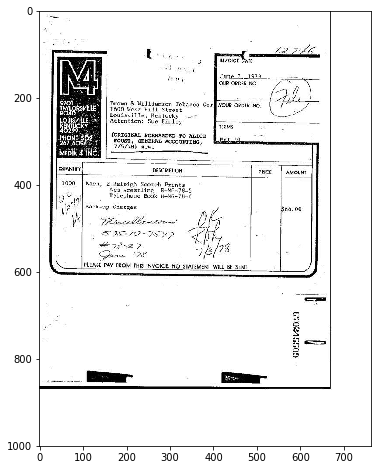

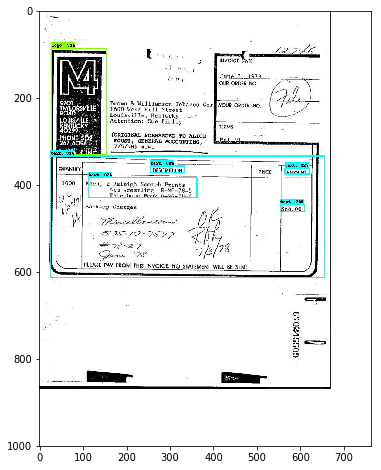

In [0]:
  

  %matplotlib inline
  
  image_path= os.path.join(TEST,'0000226477.jpg')
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  #plt.figure(figsize=IMAGE_SIZE)
  #plt.imshow(image_np)
  #plt.show()
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()
  rescaled = (255.0 / image_np.max() * (image_np - image_np.min())).astype(np.uint8)

  im = Image.fromarray(rescaled)
  im.save(os.path.join(OUTPUT,'test.jpg')
  

## Test with All Images in Test folder

In [80]:
os.chdir(TRAINING_OD)
os.getcwd()

'/content/drive/My Drive/RFCN_Project/workspace/training_OD'

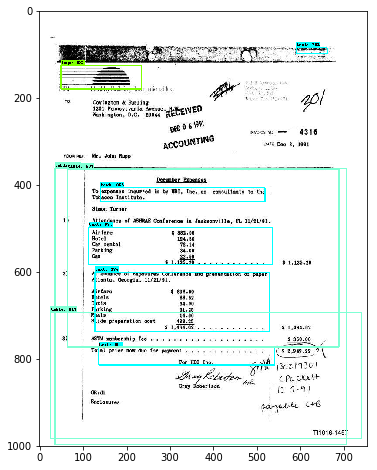

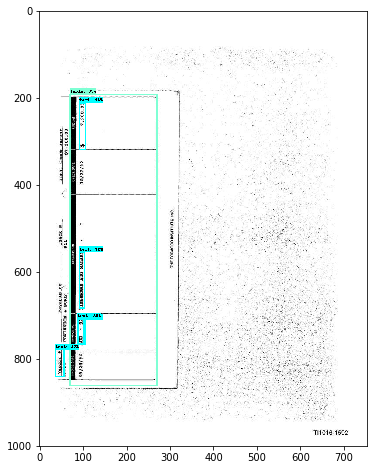

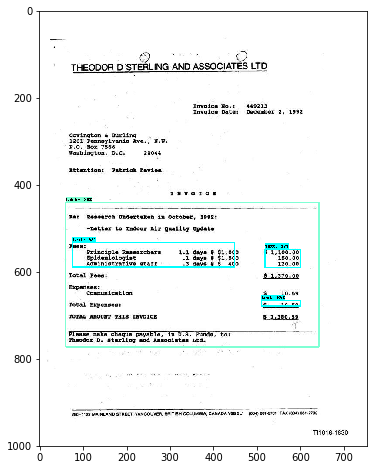

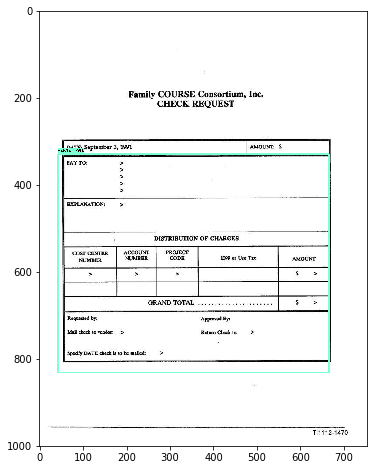

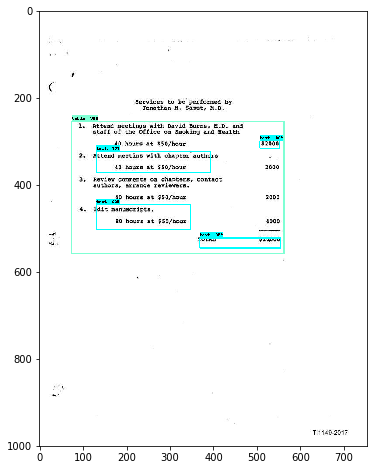

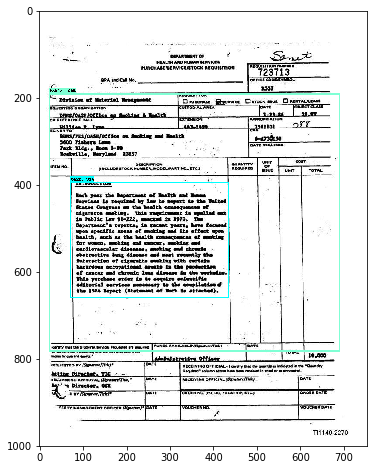

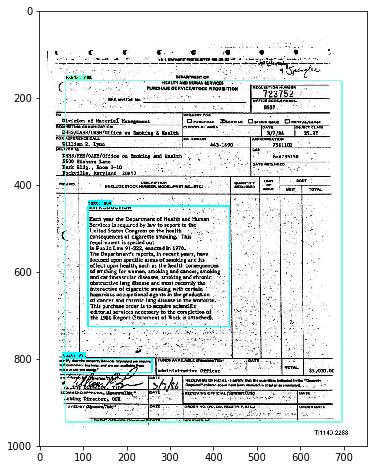

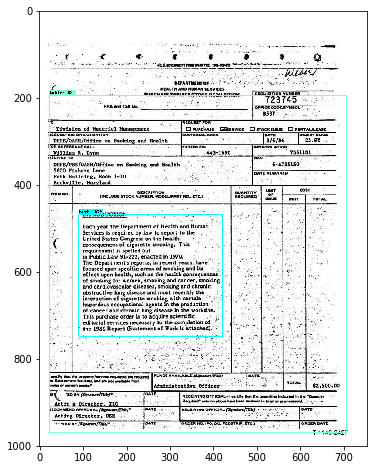

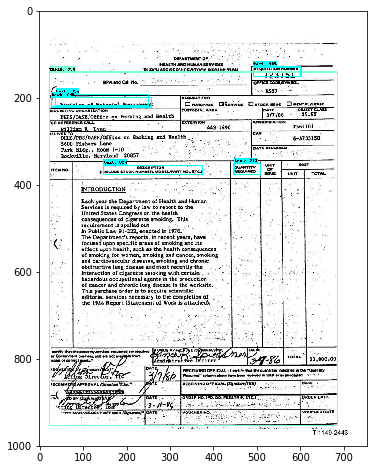

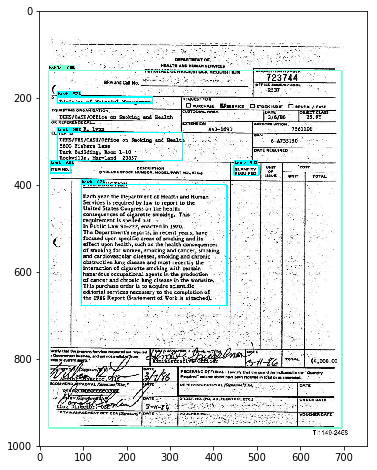

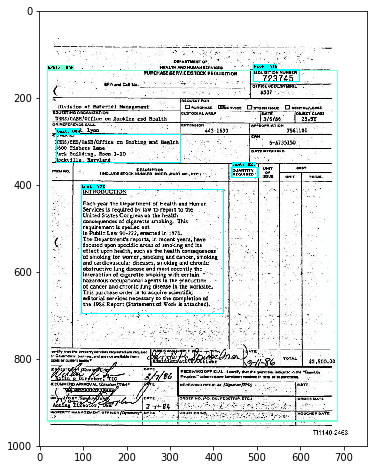

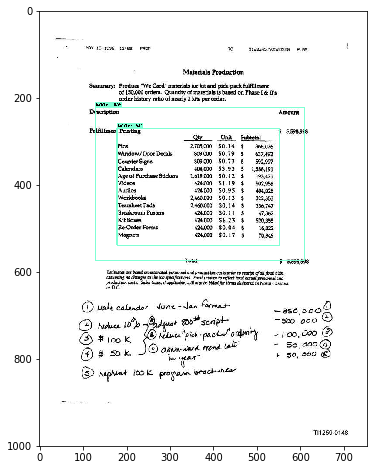

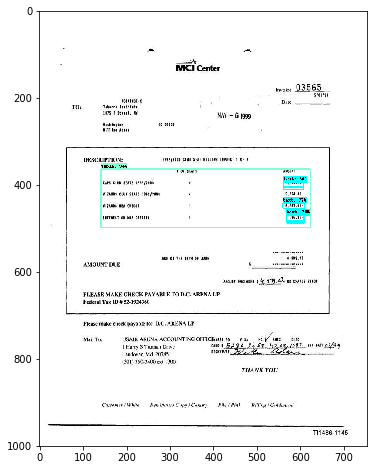

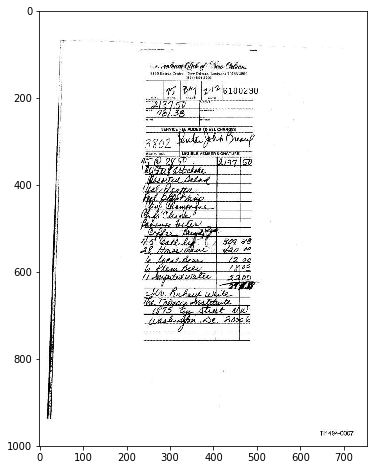

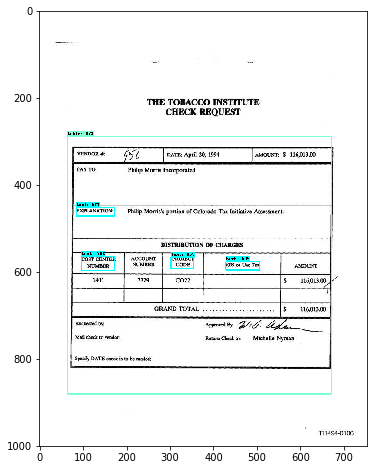

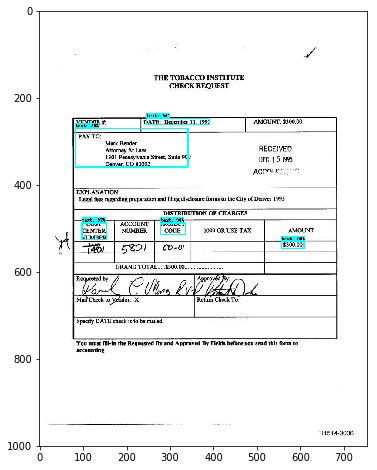

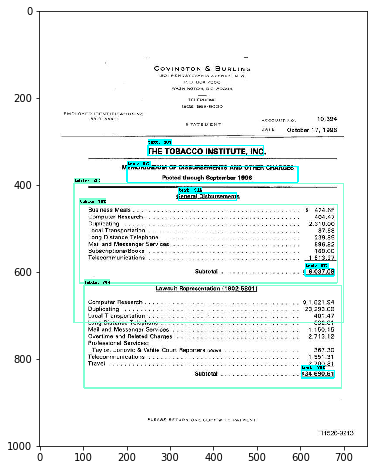

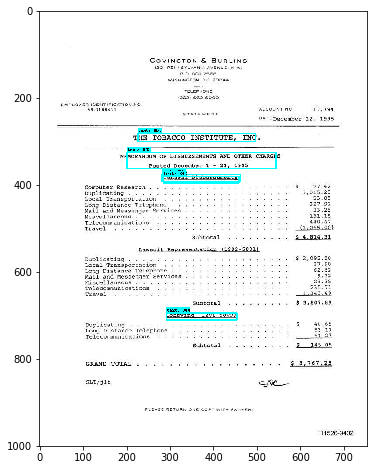

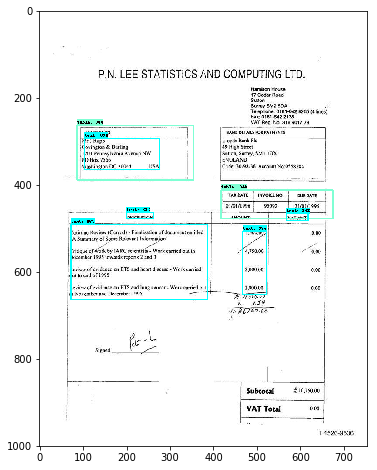

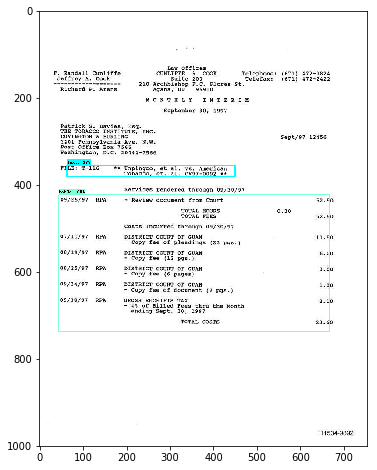

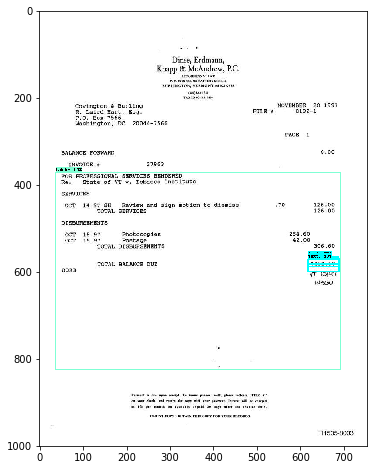

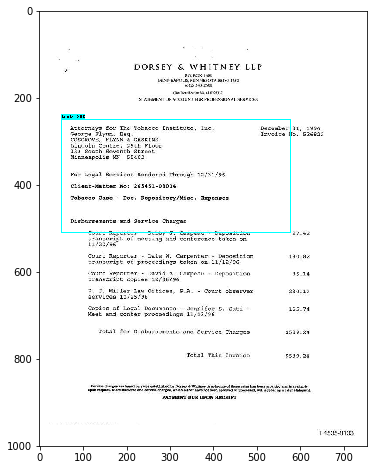

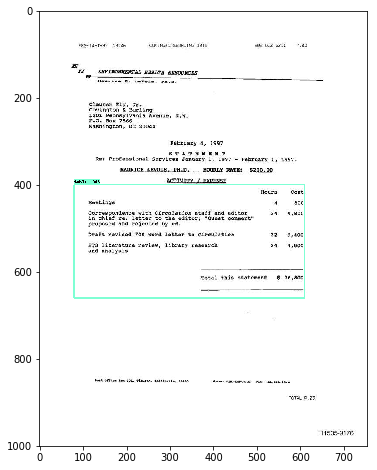

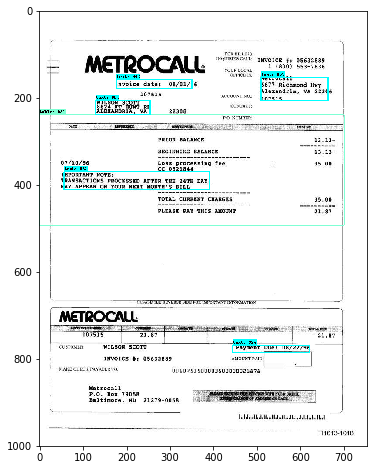

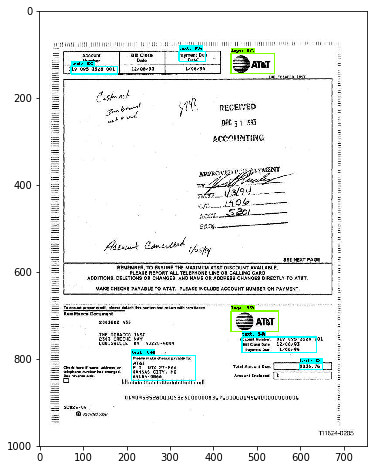

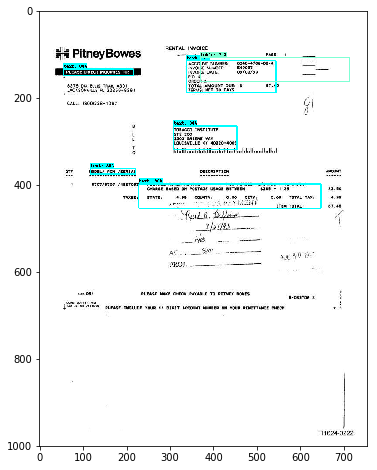

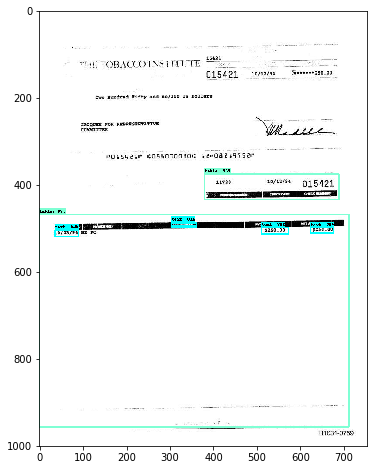

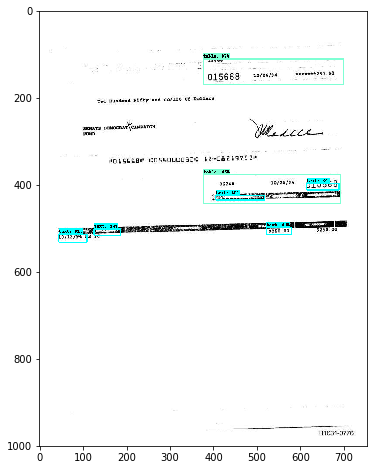

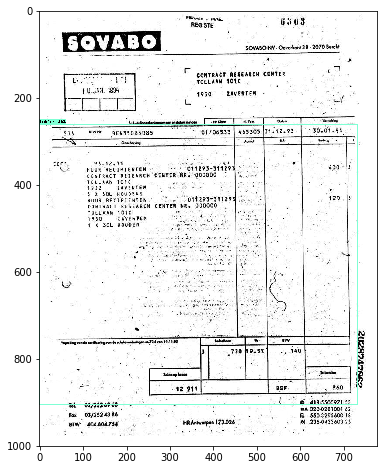

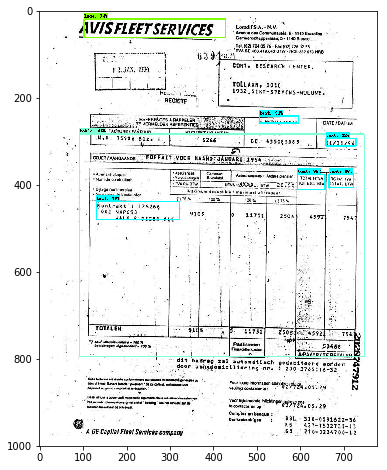

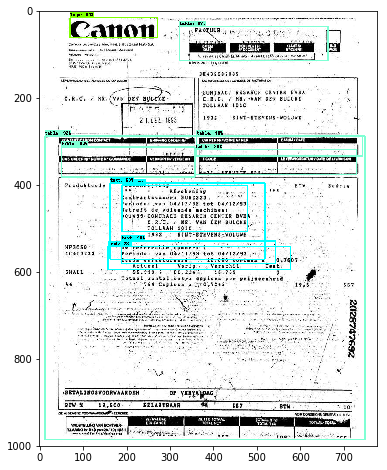

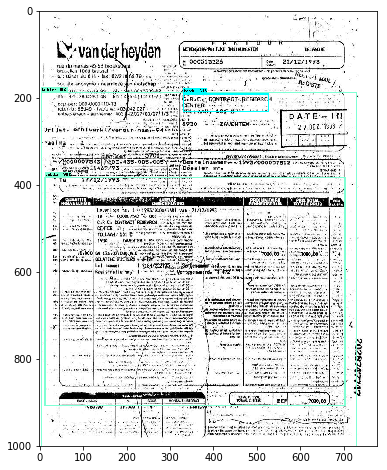

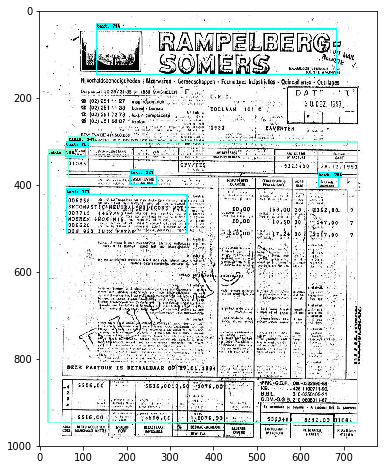

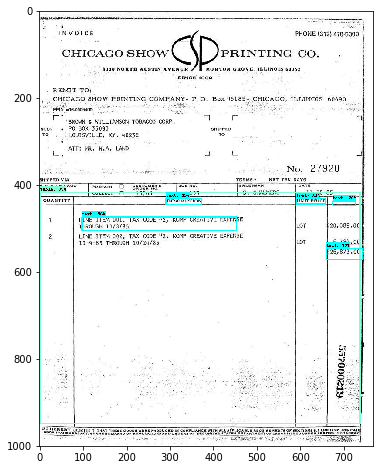

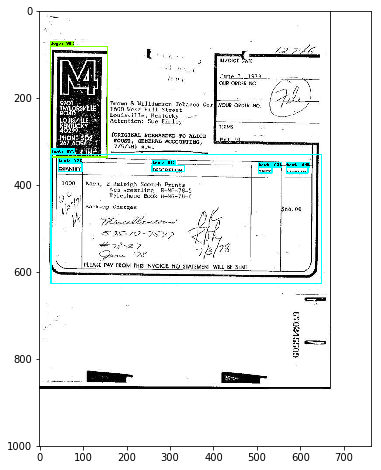

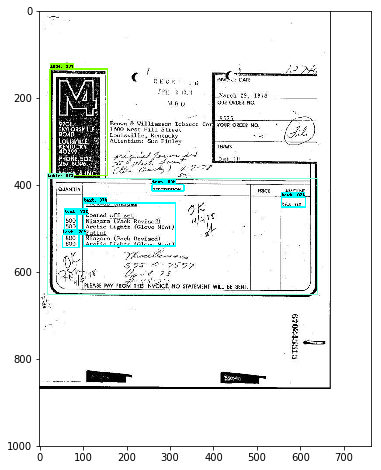

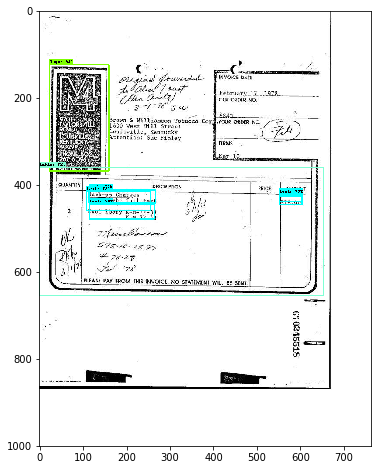

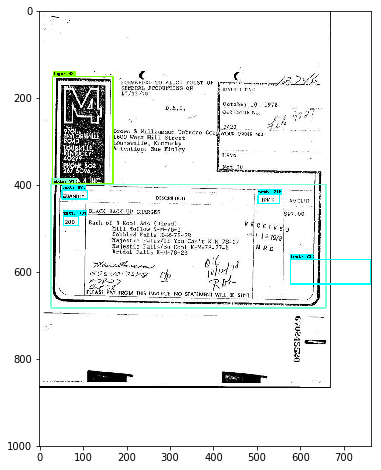

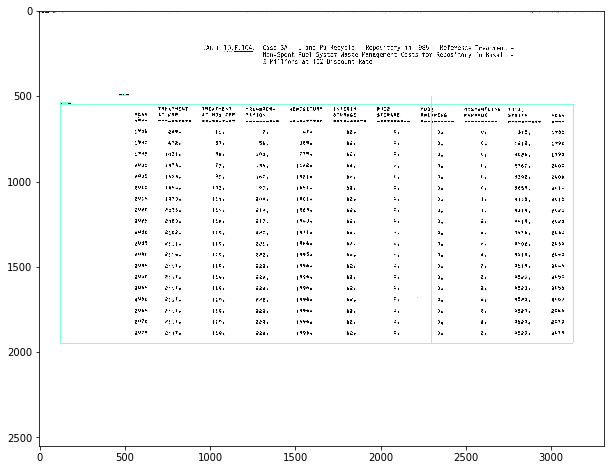

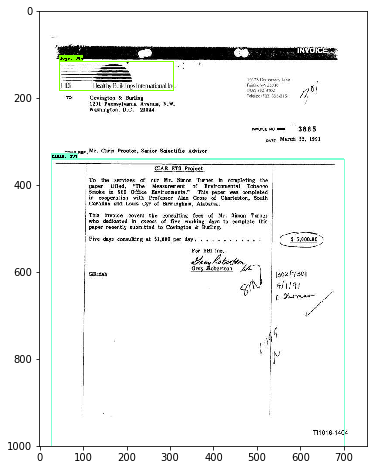

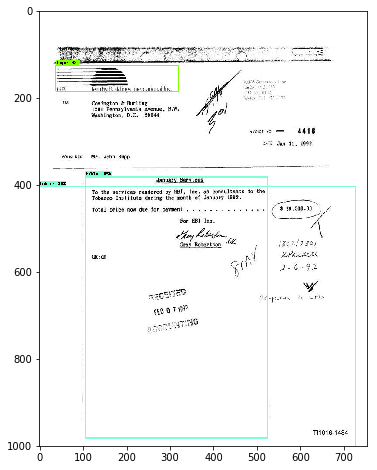

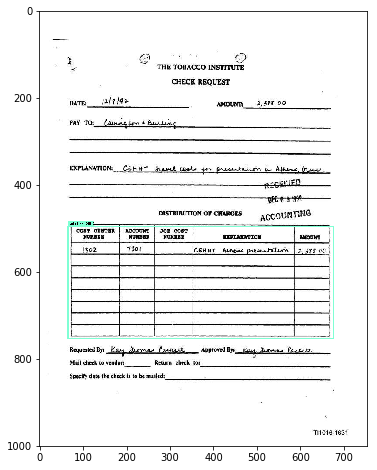

In [0]:
%matplotlib inline
PATH_TO_TEST_IMAGES_DIR =TEST
data_paths = [i for i in (os.path.join(PATH_TO_TEST_IMAGES_DIR, f) for f in os.listdir(PATH_TO_TEST_IMAGES_DIR)) if os.path.isfile(i)]

i=0 ;
for image_path in data_paths:
  i = i + 1 
  
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.show()
  rescaled = (255.0 / image_np.max() * (image_np - image_np.min())).astype(np.uint8)

  im = Image.fromarray(rescaled)
  im.save(os.path.join(OUTPUT,'test{}.jpg'.format(i)))